In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Performance Evaluation of Terapixel rendering in Cloud (Super)computing 

## Background
Similar to other projects which use high resources and intensive calculation (in this case rendering very large image), the large scale project of Terapixel 3D city visualisation needs to be evaluated.
This project is an evaluation project to inverstigate on how the rendering task is managed by the Cloud Supercomputing based on resources utilisation. The expected output of this project is complete analysis of the performance differences between the GPUs. There are 1024 unique GPUs which the rendering tasks are dispatched. 

## Methods
### Project Management
This project will refer to normal data science project although not all steps will be done.
### Tools
There will be several tools and technology that are used in this project. Programming language use Python and using Jupyter Notebook as literate programming tools. Next, MongoDB is used for persistent database and Docker as virtualisation tools and contained for the MongoDB database.
#### persistent database vs cache/csv

#### reproducibility

### Evaluation Methods
This project implements the 12 rules from Scientific Benchmarking of Parallel Computing Systems (Hoefler and Belli, 2015).

performance should compare between duration and the utilization of the hardware. if it is utilize to the fullest (i.e. more than 80% utilization) and also duration is short.

it can be started by find the shortest duration and then continue to compare it with the longer duration to see if there is some decreasing utilization of the software. On the other hand make sure it is on the same level of difficulty which in this case might be related to level (4 or 8 or 12) or related to tile position (x and y)

it will be good if task type can be shown in scatter plot.Compare between average gpu utilization and  

check how many task that completed for each GPU

in terms of GPU activity, the tasks distributed normally with distribution range between 1450 and 1500. On the other hand in terms of the task dispatching each GPU/hostname can be seen on table below:

In [4]:
from pymongo import MongoClient
import pandas as pd
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import stats
#from sklearn.decomposition import PCA

In [5]:
## connect to Database
client = MongoClient()
client = MongoClient('localhost', 3306)
db = client.csv_merge

In [6]:
taskset = db.taskIds
db_application_checkpoints = db.apps
db_task_XY = db.taskXY
db_gpu = db.gpu

df = pd.DataFrame(list(taskset.find()))
df.columns

Index(['_id', 'duration', 'eventName', 'startTime', 'stopTime', 'taskid'], dtype='object')

In [7]:
db_application_checkpoints = db.apps
db_task_XY = db.taskXY
db_gpu = db.gpu
db_gpu_master = db.gpu_master
db_task_ids = db.taskids_host
db_task_gpu_tile = db.task_gpu_tile
db_task_gpu = db.task_gpu

In [ ]:
df_application_checkpoints = pd.DataFrame(list(db_application_checkpoints.find().limit(3)))
df_gpu = pd.DataFrame(list(db_gpu.find().limit(3)))
df_task_XY = pd.DataFrame(list(db_task_XY.find().limit(3)))
df_gpu_master = pd.DataFrame(list(db_gpu_master.find().limit(3)))
df_task_ids = pd.DataFrame(list(db_task_ids.find().limit(3)))
df_task_gpu_tile = pd.DataFrame(list(db_task_gpu_tile.find().limit(3)))
df_task_gpu = pd.DataFrame(list(db_task_gpu.find().limit(3)))

## Implementation
Using some subset from CRISP-DM framework, the implementation phase includes Data Understanding and Data Preparation.

### Data Understanding
There are three raw datasets and 3 additionals that are used for this project. These six datasets stored in MongoDB persistend database for easy and efficient access. 

### Data preparation
There are three raw datasets and 3 additionals that are used for this project. These six datasets stored in MongoDB persistend database for easy and efficient access. 

#### Application checkpoints

In [5]:
df_application_checkpoints.iloc[:,[1,2,3,4,5,6]]

,eventName,eventType,hostname,jobId,taskId,timestamp
0,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000N,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043,2018-11-08T07:41:55.921Z
1,Saving Config,START,0d56a730076643d585f77e00d2d8521a00000N,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,2018-11-08T07:42:29.842Z
2,Saving Config,STOP,0d56a730076643d585f77e00d2d8521a00000N,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d,2018-11-08T07:42:29.845Z


#### GPU Utilisation

In [6]:
df_gpu.iloc[:,[1,2,3,4,5,6,7,8]]

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,hostname,powerDrawWatt,timestamp
0,53,323217055910,48,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,92,8b6a0eebc87b4cb2b0539e81075191b900001C,131.55,2018-11-08T08:27:10.314Z
1,48,323617020295,40,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,92,d8241877cd994572b46c861e5d144c85000000,117.03,2018-11-08T08:27:10.192Z
2,44,323217056562,45,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,91,db871cd77a544e13bc791a64a0c8ed50000006,121.64,2018-11-08T08:27:10.842Z


#### Mapping between image tile and the rendering task

In [7]:
df_task_XY.iloc[:,[1,2,3,4,5]]

,jobId,level,taskId,x,y
0,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,00004e77-304c-4fbd-88a1-1346ef947567,116,178
1,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,142,190
2,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,0003c380-4db9-49fb-8e1c-6f8ae466ad85,142,86


Based on these three datasets, generated several other datasets to help with explaratory data analysis later. These additional datasets were created using merge, join and group by.

#### GPU Master
Dataset that contains all 1024 unique GPU and hostname information including the serial number and unique-id.

In [8]:
df_gpu_master.iloc[:,[1,2,3,4]]

,gpuSerial,gpuUUID,hostname,hostnumber
0,320118118607,GPU-c926aca5-c234-0d79-0778-d4672fedc0d6,5903af3699134795af7eafc605ae5fc700000E,1
1,320118118641,GPU-ce6cb6dd-5be7-934b-ff1b-c156725497ba,95b4ae6d890e4c46986d91d7ac4bf082000005,2
2,320118118702,GPU-317830c7-3b7b-0770-0d88-85585d11fce4,95b4ae6d890e4c46986d91d7ac4bf08200000Y,3



#### Task Detail 
Task detail dataset is basically similar to "application checkpoints" dataset but instead of store the "start time" and "stop time" in different records it store it in one record and by put them in one record the duration can be calculated. In this dataset each task will have 5 records that representing the event name (i.e. Render, Tiling, Uploading, Total Render and Saving Config). The new column (duration) store the difference between stopTime- startTime and it's unit measure in milliseconds(1/1000 second).

In [9]:
df_task_ids.iloc[:,[1,2,3,4,5,6,7]]

,duration,eventName,hostname,jobId,startTime,stopTime,taskid
0,1013.0,Tiling,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:03:28.214000,2018-11-08 08:03:29.227000,fe81b1e2-7466-4e13-8392-e3a3434421ad
1,48174.0,TotalRender,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:02:41.210000,2018-11-08 08:03:29.384000,fe81b1e2-7466-4e13-8392-e3a3434421ad
2,2.0,Saving Config,95b4ae6d890e4c46986d91d7ac4bf08200000U,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08 08:02:41.210000,2018-11-08 08:02:41.212000,fe81b1e2-7466-4e13-8392-e3a3434421ad


Based on these three datasets, generated several other datasets to help with explaratory data analysis later. These additional datasets were created using merge, join and group by.

#### Task GPU and Tile dataset
This dataset combines the three original dataset into one table for ease of access.

In [11]:
df_task_gpu_tile.iloc[:,[1,2,3,4,5,6,7]]

,gpu,hostname,jobid,start,stop,taskid,tilexy
0,"[{'gpuSerial': 325017017635, 'gpuUUID': 'GPU-3...",b9a1fa7ae2f74eb68f25f607980f97d700000K,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:02:28.268Z,2018-11-08T08:03:18.691Z,e97027d1-e243-4c43-aa83-7489b85e00b4,"{'x': 14, 'y': 83, 'level': 12}"
1,"[{'gpuSerial': 323617020988, 'gpuUUID': 'GPU-5...",db871cd77a544e13bc791a64a0c8ed50000009,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:28:07.856Z,2018-11-08T08:28:50.437Z,9e26a62e-4b49-40b5-ba43-e0dec6191f9b,"{'x': 176, 'y': 203, 'level': 12}"
2,"[{'gpuSerial': 323617042980, 'gpuUUID': 'GPU-a...",2ecb9d8d51bc457aac88073f6da05461000015,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,2018-11-08T08:02:15.540Z,2018-11-08T08:02:47.559Z,16b39d16-8ae9-4dfc-9eaf-2b3560ecb626,"{'x': 120, 'y': 193, 'level': 12}"



#### Task-GPU detail -> no sample
This dataset combines the two original dataset Application checkpoints and GPU utilisation in order to get information about GPU utilisation data that specifically used when event Render. 
Dataset limited to classification of Render or non-Render GPU utilisation, because time limitation to process the data.

In [37]:
dataframe3 = pd.merge(df[df['eventName'] != 'TotalRender'], df[df['eventName'] == 'TotalRender'], on='taskid', how='left')

In [38]:
dataframe3 = dataframe3.iloc[:, [1, 2, 5, 7]]

In [39]:
def percentage_func(row):
    return (row['duration_x'] / row['duration_y']) * 100

dataframe3['percentage'] = dataframe3.apply(percentage_func, axis=1)


## Exploratory Data Analysis Result
This part contains the Exploratory Data Analaysis that is done to fulfill the objective.

### Event Duration per Task
To get a good insight about processes that run in a task, analyse the correlation between task and event.

Table below shows one task and all events in it. Each task actually contains of five events (Total Render, Saving Config, Render, Tiling and Uploading), but because it is actually the sum of the other four event hence "Total Render" event is not included in the table.

In [15]:
dataframe3[dataframe3['taskid'] == 'fe81b1e2-7466-4e13-8392-e3a3434421ad']

,duration_x,eventName_x,taskid,duration_y,percentage
0,1013.0,Tiling,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,2.102794
1,2.0,Saving Config,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,0.004152
2,46995.0,Render,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,97.552622
3,1177.0,Uploading,fe81b1e2-7466-4e13-8392-e3a3434421ad,48174.0,2.443227




Bar graph below shows that event "Render" dominates the runtimes of the task. From the total 48 second, it takes 46 (more than 97%) seconds to finish the Render.

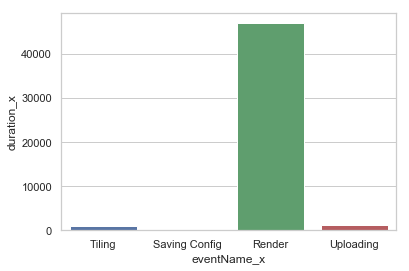

In [43]:
sns.set(style="whitegrid")
sns.barplot(x = 'eventName_x', y='duration_x', data=dataframe3[dataframe3['taskid'] == 'fe81b1e2-7466-4e13-8392-e3a3434421ad'])


The comparison for all the tasks it shows using violin plot below for better comparisons. The box plot shows that the majority percentages of the Render more than 95% although there are some outliers that fall below 40%. For Uploading event the majority percentages below 10% but the outliers can increase until more than 40%.

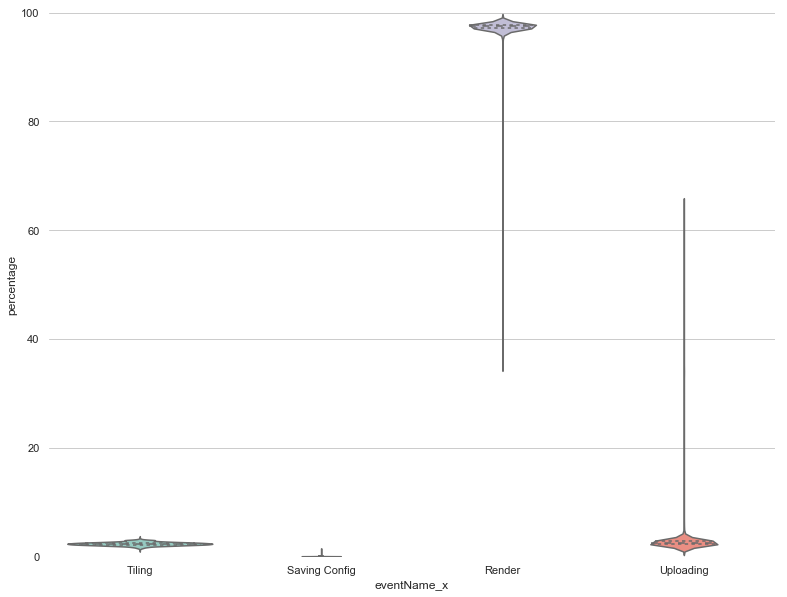

In [42]:
sns.set(style="whitegrid")
a4_dims = (13, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(ax = ax, x="eventName_x", y="percentage", inner='quartile', palette="Set3", data=dataframe3)

# Finalize the figure
ax.set(ylim=(0, 100))
sns.despine(left=True, bottom=True)

In [19]:
df_gpu = pd.DataFrame(list(db_gpu.find()))

In [6]:
df_gpu.columns

Index(['_id', 'gpuMemUtilPerc', 'gpuSerial', 'gpuTempC', 'gpuUUID',
       'gpuUtilPerc', 'hostname', 'powerDrawWatt', 'timestamp'],
      dtype='object')

In [20]:
df_gpu = df_gpu.iloc[:, [1,3,5,7]]
df_gpu.head()

,gpuMemUtilPerc,gpuTempC,gpuUtilPerc,powerDrawWatt
0,53,48,92,131.55
1,48,40,92,117.03
2,44,45,91,121.64
3,43,38,90,50.23
4,47,41,90,141.82


### Interplay between variables in GPU
Correlation table and heat map below show the correlation between four variables of GPU. They are Memory Utilisation (percentages), Temperature (Celcius), Core Utilisation (percentages) and Power Draw (watts). All the variables have positives relation between them. 
Furthermore,on the next discussion these four variables will be called performance features.


,gpuMemUtilPerc,gpuTempC,gpuUtilPerc,powerDrawWatt
gpuMemUtilPerc,1.000000,0.492783,0.966571,0.870745
gpuTempC,0.492783,1.000000,0.505906,0.537191
gpuUtilPerc,0.966571,0.505906,1.000000,0.862673
powerDrawWatt,0.870745,0.537191,0.862673,1.000000


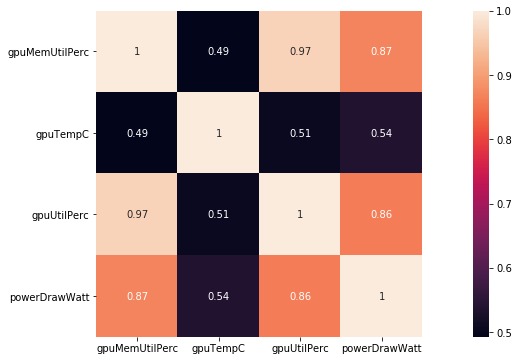

In [36]:
a4_dims = (18, 6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_gpu.corr(), vmax=1, square=True, annot=True)
df_gpu.corr()

#### Correlation between Temperature and Performance
From above graph, the correlation between Temperature and Utilisation is 0.51 and this value can be interpreted as intermediate positive correlation between Temperature and Performance. Positive value inidicates the higher utilisation is directly proportional with higher temperature of GPU and vice versa. On the other hand the value is still below 60% hence it is not a strong relationship and indicates it is not very sensitive with changes. 

This correlation is make sense due to the nature of temperature that can't change rapidly compare to the utilisation that can change rapidly. This nature probably the impact the intermediate correlation.

##### chicken and egg causalisation dillema 
There is a situation that at some point (i.e. maximum operating temperature) the high temperature will lower the performance (i.e. performance drop). This project maximum GPUs temperature (55 Celcius) still below the maximum operating and slow down temperatures (85 and 87 Celcius) as stated in GPU formal specification hence there is no anomaly case. (Images.nvidia.com, 2019)

In [41]:
df_gpu.max()

gpuMemUtilPerc     83.00
gpuTempC           55.00
gpuUtilPerc       100.00
powerDrawWatt     197.01
dtype: float64

### Render Time
After discuss about correlation between each GPU variables and pointing out that all four variables have intermediate to strong positive connection each other, in this chapter will be discussed about how an event or task execution affect the four performance features.

The dataset contains more than 65000 different task execution records and it takes a lot of memory and time to visualise, therefore in this chapter for better visualisation and also to save time only 100 tasks is discussed.  

In [258]:
db_task_gpu2 = db.task_gpu_class
df_task_gpu2 = pd.DataFrame(list(db_task_gpu2.find()))

#df_task_gpu2 = pd.DataFrame(list(db_task_gpu2.find()))
df_task_gpu2.columns

Index(['_id', 'eventname', 'gpuMemUtilPerc', 'gpuSerial', 'gpuTempC',
       'gpuUUID', 'gpuUtilPerc', 'hostname', 'powerDrawWatt', 'taskid',
       'timestamp'],
      dtype='object')

In [259]:
df_task_gpu2['timestamp'] = df_task_gpu2.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

In [260]:
df_task_gpu2['powerDrawWatt'] = pd.to_numeric(df_task_gpu2['powerDrawWatt'])
df_task_gpu2['gpuMemUtilPerc'] = pd.to_numeric(df_task_gpu2['gpuMemUtilPerc'])
df_task_gpu2['gpuUtilPerc'] = pd.to_numeric(df_task_gpu2['gpuUtilPerc'])
df_task_gpu2['gpuTempC'] = pd.to_numeric(df_task_gpu2['gpuTempC'])

In [261]:
df_task_gpu2 = df_task_gpu2.iloc[:, [1, 2, 3, 4, 6, 7, 8, 9, 10]]

In [262]:
df_task_gpu2 = df_task_gpu2.sort_values(by=['timestamp'])
df_task_gpu2 = df_task_gpu2.reset_index(drop=True)
df_task_gpu2['stepNumber'] = df_task_gpu2.index + 1000

df_task_gpu2.eventname.fillna('NonRender', inplace=True)


In [263]:
#df_task_gpu2[df_task_gpu2['eventname'].isnull()].head()
#df_task_gpu2['hostname'].value_counts()
df_task_gpu2.head(2)

,eventname,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUtilPerc,hostname,powerDrawWatt,taskid,timestamp,stepNumber
0,Render,0,325117062966,28,0,e7adc42d28814e518e9601ac2329c513000017,26.04,2e311b1b-0382-4588-bef0-a43d79dbd19d,2018-11-08 07:41:32.943,1000
1,Render,0,325117062966,28,0,e7adc42d28814e518e9601ac2329c513000017,26.04,2e311b1b-0382-4588-bef0-a43d79dbd19d,2018-11-08 07:41:34.962,1001


Graph below compare the increased power draw between render time and non-render time event (i.e. Saving Config, Tiling and Uploading). 
It shows that power draw when rendering is far above the non-render event time and can also be interpreted that power consumption rate will increase significantly while at render time. The maximum power consumption of non-render time is about 50 watt but it can reach more than 140 watt while rendering time.

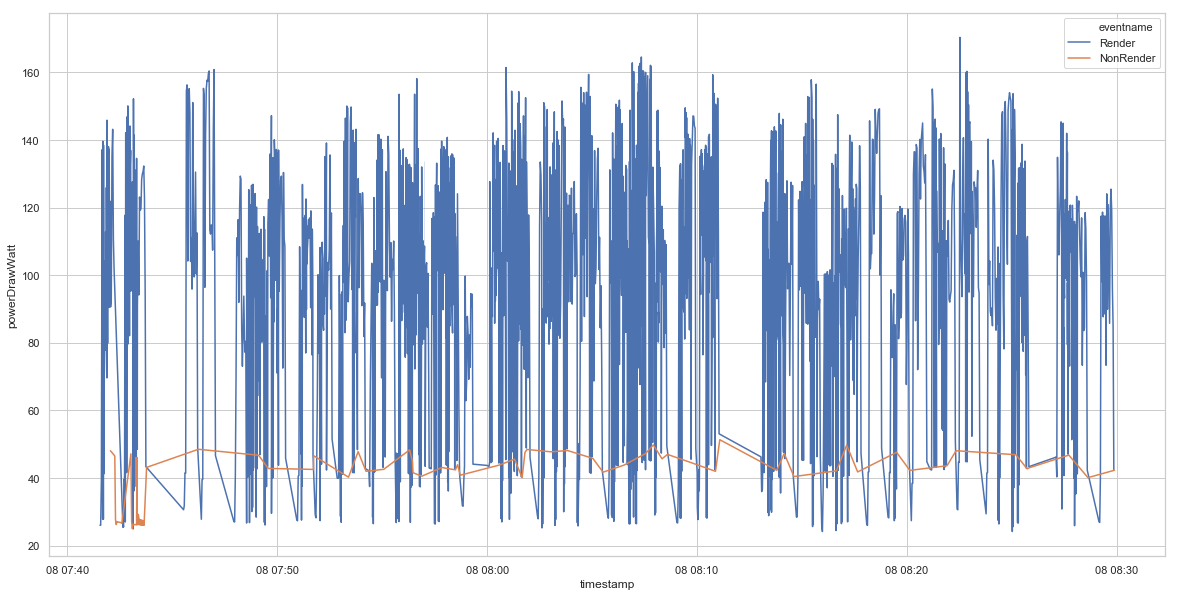

In [264]:
landscape = (20, 10)
fig1, ax1 = plt.subplots(figsize=landscape)

#sns.relplot(ax = ax1, x='stepNumber', y="powerDrawWatt", kind='line', 
#            data=df_task_gpu2[df_task_gpu2['taskid'] == '2e311b1b-0382-4588-bef0-a43d79dbd19d'])

sns.set(style="whitegrid")
        
sns.lineplot(x="timestamp", y="powerDrawWatt",
             hue="eventname",
             data=df_task_gpu2)

Computation variation can be calculated by pointing out the relationship between tiles(x, y) with the tasks and resource utilisation, from the variation it is possible to compare the different between tiles.

Quantify tiles on level 8 is one good example, is shown below.

In [9]:
taskXYset = db.taskXY
taskXYset_level8 = pd.DataFrame(list(taskXYset.find({'level': 8})))

In [10]:
taskidset2 = pd.DataFrame(list(db_task_gpu.find({'taskid': { '$in': list(taskXYset_level8['taskId']) }})))
taskidset2 = taskidset2.sort_values(by=['timestamp'])
taskidset2 = taskidset2.reset_index(drop=True)
taskidset2['stepNumber'] = taskidset2.index + 1000
len(taskidset2)

5380

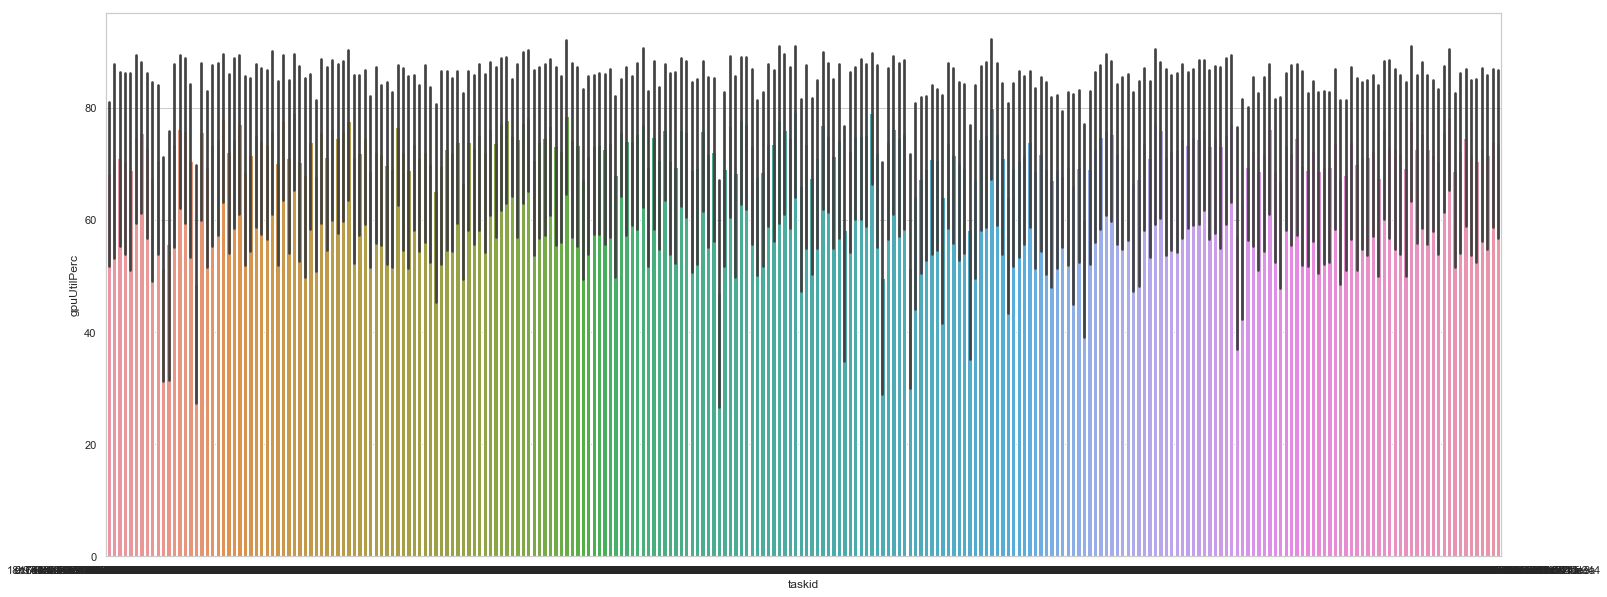

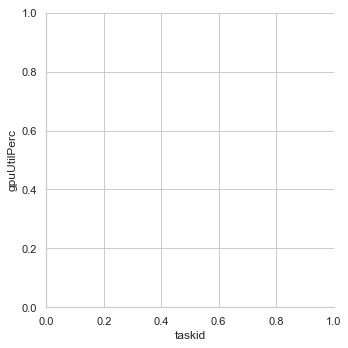

In [228]:
landscape = (20, 10)
f1, ax1 = plt.subplots(figsize=(25, 10))
sns.set(style="whitegrid")
sns.catplot(x="taskid", y="gpuUtilPerc", data=taskidset2, kind="bar", ax=ax1)


#### Summarise the computation for each tiles
According to "Rule 3" it is better to summarise data using harmonic mean or geometrics.

In [24]:
df_gpu_power_mean = taskidset2.groupby(['taskid'])['powerDrawWatt'].agg([stats.mstats.hmean])
df_gpu_power_mean.reset_index(level=0, inplace=True)

df_gpu_temp_mean = taskidset2.groupby(['taskid'])['gpuTempC'].agg([stats.mstats.hmean])
df_gpu_temp_mean.reset_index(level=0, inplace=True)

df_gpu_resource_mean = taskidset2.groupby(['taskid'])['gpuUtilPerc'].agg([np.mean])
df_gpu_resource_mean.reset_index(level=0, inplace=True)

df_gpu_memory_mean = taskidset2.groupby(['taskid'])['gpuMemUtilPerc'].agg([np.mean])
df_gpu_memory_mean.reset_index(level=0, inplace=True)

df_gpu_power_mean = pd.merge(df_gpu_power_mean, df_gpu_temp_mean, suffixes = ('_power', '_temp'),
                                left_on='taskid', right_on='taskid', how='left')
df_gpu_power_mean = pd.merge(df_gpu_power_mean, df_gpu_resource_mean, suffixes = ('', '_util'),
                                left_on='taskid', right_on='taskid', how='left')
df_gpu_power_mean = pd.merge(df_gpu_power_mean, df_gpu_memory_mean, suffixes = ('', '_memory'),
                                left_on='taskid', right_on='taskid', how='left')


In [25]:
df_gpu_resource_mean = pd.merge(df_gpu_resource_mean, df_gpu_memory_mean, suffixes = ('', '_memory'),
                                left_on='taskid', right_on='taskid', how='left')
df_gpu_resource_mean.columns

Index(['taskid', 'mean', 'mean_memory'], dtype='object')

In [26]:
df_gpu_resource_mean = df_gpu_resource_mean.melt('taskid', var_name='resource_name', value_name='percentage')

In [27]:
df_gpu_resource_mean.columns

Index(['taskid', 'resource_name', 'percentage'], dtype='object')

The bargraph below shows the variation of GPUs memory and cpu utilisation when render all the tiles in level 8. There are 256 task on level 8 tiles (16x16 tiles). The highest mean very close to 80% but on the other hand the lowest mean can reach below 50%. The difference quite far, about 30% between maximum and minumum means.

The mean for both memory and cpu utilisation calculated using arithmetic mean because both of the features contain zero(0) values and harmonic mean can calculate if list of number contains zero. 

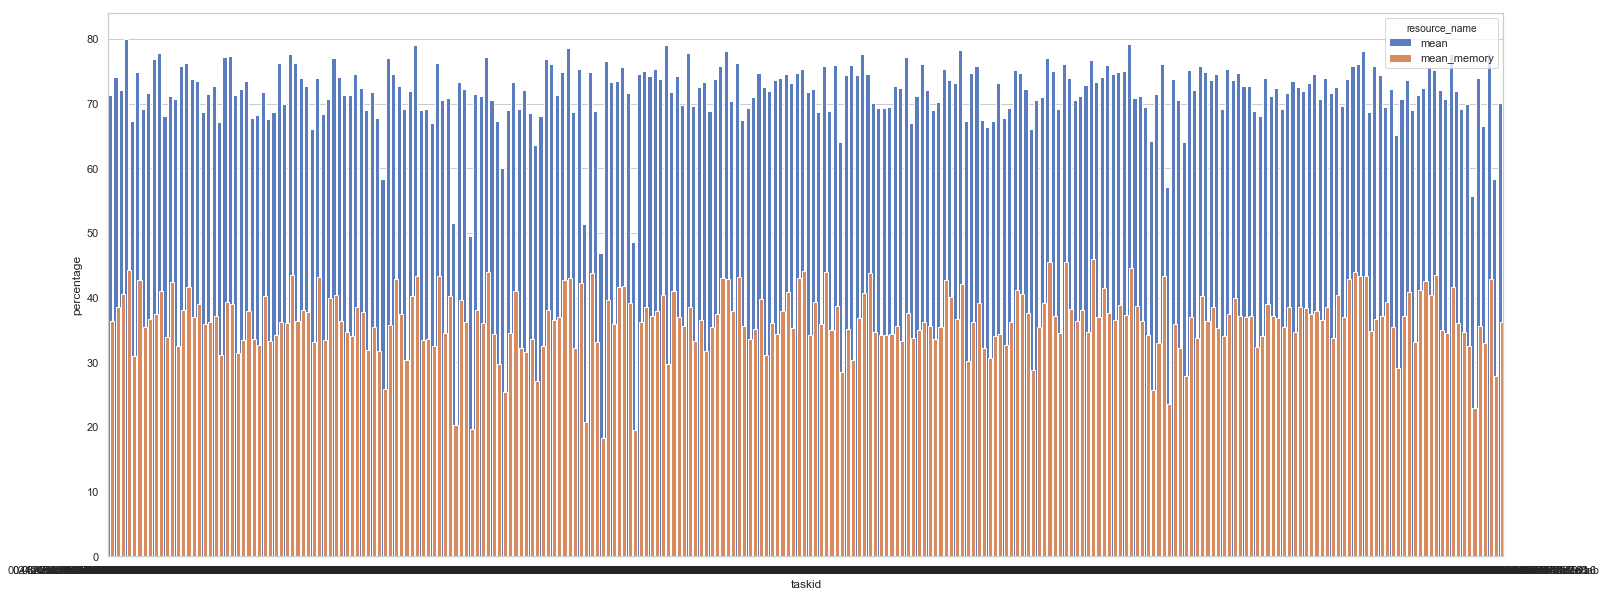

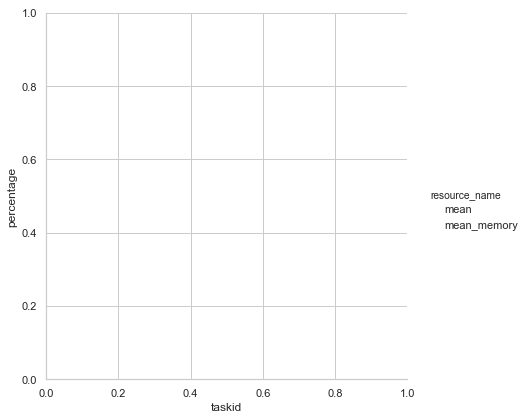

In [28]:
#df_gpu_resource_mean.head()

landscape = (20, 10)
f2, ax2 = plt.subplots(figsize=(25, 10))
sns.set(style="whitegrid")

sns.catplot(x="taskid", y="percentage", hue="resource_name", data=df_gpu_resource_mean,
                height=6, kind="bar", palette="muted", ax=ax2)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax2, .75)
plt.show()

The graph below summarises the power draw when rendering level 8 tile (256 tiles). Y axis shows the harmonic means of power draw watt for each task.

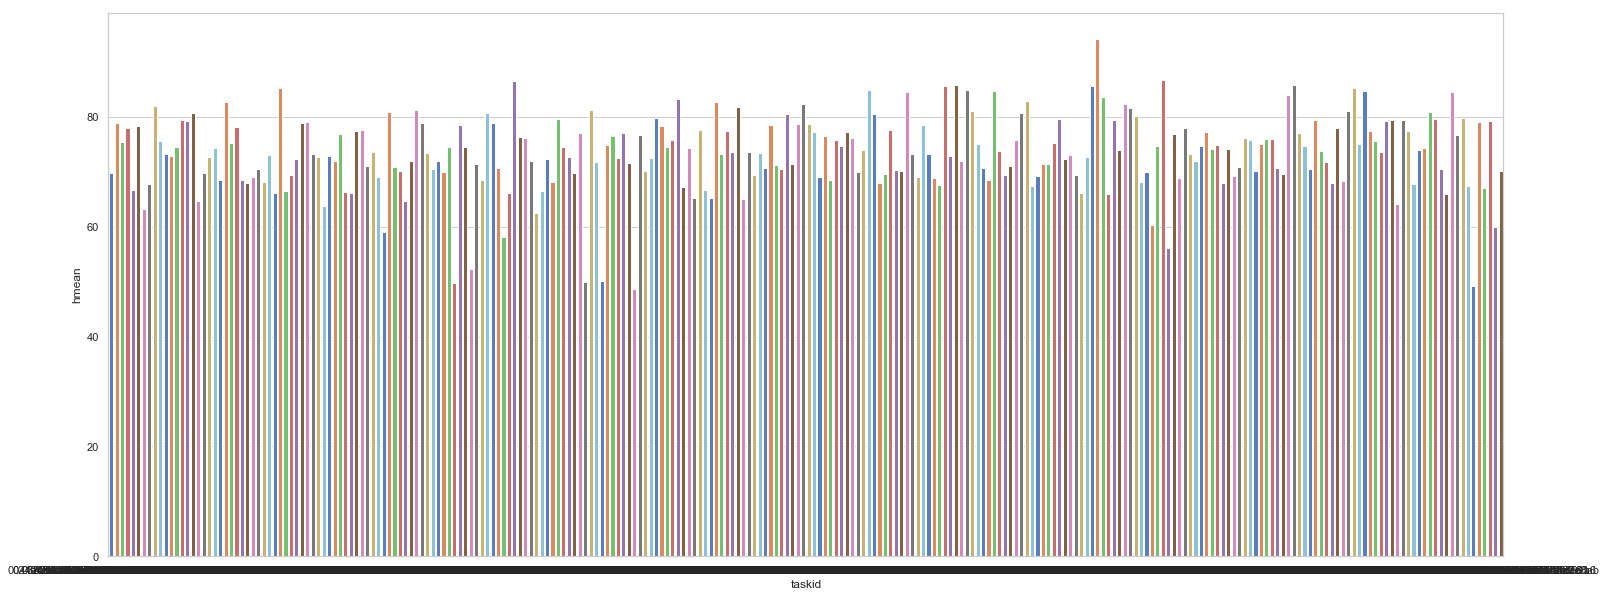

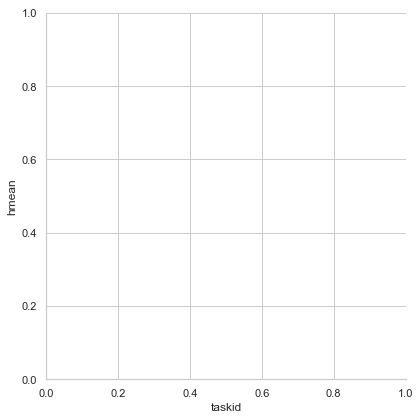

In [22]:
landscape = (20, 10)
f2, ax2 = plt.subplots(figsize=(25, 10))
sns.set(style="whitegrid")

sns.catplot(x="taskid", y="hmean", data=df_gpu_power_mean,
                height=6, kind="bar", palette="muted", ax=ax2)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax2, .75)
plt.show()

#### Comparison table

After comparing both bar graphs above, next step is to see the real value of each maximum and minimum values of three features except the temperature. 

In [43]:
df_gpu_power_mean.sort_values(by=['hmean_power'], ascending=False).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
181,b867fb90-34c5-4228-a25f-e99d2c6cbc24,94.238256,46.428657,73.272727,37.045455
193,c047a261-61be-4918-aac3-bbd3cea95277,86.659221,37.335378,76.166667,43.375000
74,458b9fe2-9e41-44c0-abb9-e97bb6f373c4,86.460905,40.397650,73.380952,41.095238
155,9ad43418-99f0-4955-819d-86ebb0245c1d,85.749909,43.428092,73.238095,36.761905
217,da6cb6b9-5b3d-4711-bca2-95951a667ef0,85.708532,39.837551,73.450000,34.700000
153,996c4094-b5ed-43bd-9bd2-526e31498dc8,85.573761,37.469139,75.272727,42.772727
180,b73b1645-c0d8-4e34-8543-05beeb874aff,85.565417,36.908912,76.782609,45.913043
228,e55f5098-8ef1-44a9-be99-e2943d698fc1,85.242147,37.568646,75.826087,44.000000
31,1cd7ca38-baaf-4dd8-8267-0312da621960,85.182791,37.293518,76.250000,36.250000
157,9c76d124-2ab9-43ff-8218-208c7ac146a1,84.866816,37.573070,67.315789,30.263158


In [45]:
df_gpu_power_mean.sort_values(by=['mean'], ascending=False).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
3,03831d0b-4939-4de1-9717-164765b90266,77.996805,39.081981,80.045455,44.318182
187,bc58adc7-3551-48c7-a1d5-af1e06df8b29,81.580973,43.056046,79.227273,44.545455
56,3543bebe-ed54-498e-9734-83a412651a88,81.201860,35.839663,79.125000,43.375000
102,672c8eaf-ed9b-45f9-8cc0-09ee8f28d60d,74.548934,40.855131,79.000000,29.800000
84,54a67432-9e80-45b3-a8d0-f607c99f57ae,72.648192,34.397578,78.600000,43.050000
156,9c1905ad-3967-4ade-9d37-3f6022f53e1a,72.025255,37.322779,78.227273,42.090909
230,e5881d3a-72f0-45f6-a2c4-d3361df1ce39,84.685451,34.762280,78.136364,43.272727
113,6cb4efe0-bff6-4bae-aa6a-9a9cece7da82,77.382096,35.040183,78.080000,42.800000
253,feb580b7-e879-40f2-aa57-28f3872af561,79.224391,38.383608,77.791667,42.833333
9,0affeea4-20fa-4bc5-82e0-cb96fb13bd8d,75.544546,37.254049,77.760000,41.040000


In [47]:
df_gpu_power_mean.sort_values(by=['mean_memory'], ascending=False).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
180,b73b1645-c0d8-4e34-8543-05beeb874aff,85.565417,36.908912,76.782609,45.913043
172,ae52aa1e-f93d-49bf-9a7e-f5ef97332a04,71.495855,34.978330,77.043478,45.521739
175,b1d05110-afb9-4737-be3f-6369a2385ebd,72.301664,35.885530,76.043478,45.478261
187,bc58adc7-3551-48c7-a1d5-af1e06df8b29,81.580973,43.056046,79.227273,44.545455
3,03831d0b-4939-4de1-9717-164765b90266,77.996805,39.081981,80.045455,44.318182
127,83064f91-5a19-4526-8673-38ab28dd3ab7,82.296175,38.945759,75.318182,44.136364
228,e55f5098-8ef1-44a9-be99-e2943d698fc1,85.242147,37.568646,75.826087,44.000000
69,4173f279-cfe8-4c4e-a471-ac122cc1470b,80.716691,42.761088,77.125000,44.000000
131,8444fe93-8a18-4cb2-81ee-0a8c7ff278b5,76.541702,36.969915,75.782609,43.956522
139,87f18873-d469-472e-87c8-ff460edb01ff,84.863284,34.911909,74.545455,43.863636


The next three tables compares the ten lowest means from power draw, utilisation and memory. Several tasks appear in all three tables, for example "638044d9-16a0-4ee7-a5e0-b594883fc85c", "5d1e1704-46cb-44c3-bbeb-1fc13f238317" and "38ea5505-6869-4ded-9b08-e47714015f0a".

Later on the next chapter, these results will be compared with duration of each task. This can be an important finding because under-utilisation can effect to duration (make it longer to finish tasks). 

In [44]:
df_gpu_power_mean.sort_values(by=['hmean_power'], ascending=True).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
96,638044d9-16a0-4ee7-a5e0-b594883fc85c,48.622577,31.073569,48.583333,19.583333
250,fb9f46a2-a940-4773-996f-6db2204350d2,49.253769,32.019215,55.636364,22.909091
63,38ea5505-6869-4ded-9b08-e47714015f0a,49.780649,31.494895,51.500000,20.250000
87,58ed7e09-f8d5-4745-a11d-148299bc2e9d,49.990743,33.229061,51.416667,20.833333
90,5d1e1704-46cb-44c3-bbeb-1fc13f238317,50.167300,33.131466,46.916667,18.250000
66,3db75c4b-e0be-4a77-a1a0-b8077be2e5e7,52.224964,34.369850,49.583333,19.750000
194,c21a045f-acb5-4ec3-b834-fc8ed4e63ccd,56.065699,34.685909,57.153846,23.615385
72,4405cf75-3fcb-4efc-b81f-9bbde0b677f1,58.037414,39.227786,60.062500,25.375000
50,2b0c31b3-df35-4b7e-9130-499e2e963969,59.026022,36.521547,58.266667,25.933333
254,ff1758b0-0a39-4f72-be8e-8ead79d691a6,59.931157,35.542914,58.266667,27.800000


In [46]:
df_gpu_power_mean.sort_values(by=['mean'], ascending=True).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
90,5d1e1704-46cb-44c3-bbeb-1fc13f238317,50.167300,33.131466,46.916667,18.250000
96,638044d9-16a0-4ee7-a5e0-b594883fc85c,48.622577,31.073569,48.583333,19.583333
66,3db75c4b-e0be-4a77-a1a0-b8077be2e5e7,52.224964,34.369850,49.583333,19.750000
87,58ed7e09-f8d5-4745-a11d-148299bc2e9d,49.990743,33.229061,51.416667,20.833333
63,38ea5505-6869-4ded-9b08-e47714015f0a,49.780649,31.494895,51.500000,20.250000
250,fb9f46a2-a940-4773-996f-6db2204350d2,49.253769,32.019215,55.636364,22.909091
194,c21a045f-acb5-4ec3-b834-fc8ed4e63ccd,56.065699,34.685909,57.153846,23.615385
50,2b0c31b3-df35-4b7e-9130-499e2e963969,59.026022,36.521547,58.266667,25.933333
254,ff1758b0-0a39-4f72-be8e-8ead79d691a6,59.931157,35.542914,58.266667,27.800000
72,4405cf75-3fcb-4efc-b81f-9bbde0b677f1,58.037414,39.227786,60.062500,25.375000


In [48]:
df_gpu_power_mean.sort_values(by=['mean_memory'], ascending=True).head(10)

,taskid,hmean_power,hmean_temp,mean,mean_memory
90,5d1e1704-46cb-44c3-bbeb-1fc13f238317,50.167300,33.131466,46.916667,18.250000
96,638044d9-16a0-4ee7-a5e0-b594883fc85c,48.622577,31.073569,48.583333,19.583333
66,3db75c4b-e0be-4a77-a1a0-b8077be2e5e7,52.224964,34.369850,49.583333,19.750000
63,38ea5505-6869-4ded-9b08-e47714015f0a,49.780649,31.494895,51.500000,20.250000
87,58ed7e09-f8d5-4745-a11d-148299bc2e9d,49.990743,33.229061,51.416667,20.833333
250,fb9f46a2-a940-4773-996f-6db2204350d2,49.253769,32.019215,55.636364,22.909091
194,c21a045f-acb5-4ec3-b834-fc8ed4e63ccd,56.065699,34.685909,57.153846,23.615385
72,4405cf75-3fcb-4efc-b81f-9bbde0b677f1,58.037414,39.227786,60.062500,25.375000
191,bf3d4765-dacc-4203-8d09-3b7d44a39e3b,60.316171,39.083907,64.187500,25.687500
50,2b0c31b3-df35-4b7e-9130-499e2e963969,59.026022,36.521547,58.266667,25.933333


In [30]:
df_gpu_power_mean.columns

Index(['taskid', 'hmean_power', 'hmean_temp', 'mean', 'mean_memory'], dtype='object')

### GPUs Performance Summary

In [ ]:
durations_l8 = df_duration_l8.pivot("y", "x", "duration")
durations_l8.sort_index(level=0, ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(durations_l8, annot=True,  linewidths=.5, ax=ax)

lowest = fb9f46a2-a940-4773-996f-6db2204350d2
highest = 5e0c7e56-dd20-413f-ad75-feda4ccf17b2	

In [87]:
lowest_task_duratin_df = pd.DataFrame(list(task_gpu_tile_set.find({'taskid': 'fb9f46a2-a940-4773-996f-6db2204350d2'})))
gpu_lowest_duration_df = pd.DataFrame(list(lowest_task_duratin_df['gpu']))
json3 = json.loads(gpu_lowest_duration_df.to_json(orient='records'))[0]
gpu_lowest_duration_df = pd.DataFrame(json3)
gpu_lowest_duration_df = gpu_lowest_duration_df.T
gpu_lowest_duration_df = gpu_lowest_duration_df.sort_values(by=['timestamp'])
gpu_lowest_duration_df = gpu_lowest_duration_df.reset_index(drop=True)
gpu_lowest_duration_df['stepNumber'] = gpu_lowest_duration_df.index + 1000

highest_task_duratin_df = pd.DataFrame(list(task_gpu_tile_set.find({'taskid': '8678ac52-d86e-4789-a799-9e8970015ede'})))
gpu_highest_duration = pd.DataFrame(list(highest_task_duratin_df['gpu']))
json4 = json.loads(gpu_highest_duration.to_json(orient='records'))[0]
gpu_highest_duration = pd.DataFrame(json4)
gpu_highest_duration = gpu_highest_duration.T
gpu_highest_duration = gpu_highest_duration.sort_values(by=['timestamp'])
gpu_highest_duration = gpu_highest_duration.reset_index(drop=True)
gpu_highest_duration['stepNumber'] = gpu_highest_duration.index + 1000


In [88]:
gpu_lowest_duration_df

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp,stepNumber
0,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,25.25,2018-11-08T07:41:50.886Z,1000
1,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,25.25,2018-11-08T07:41:52.905Z,1001
2,0,323617020145,30,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,0,34.96,2018-11-08T07:41:54.922Z,1002
3,21,323617020145,31,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,33,61.81,2018-11-08T07:41:56.938Z,1003
4,33,323617020145,32,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,81,69.69,2018-11-08T07:41:58.956Z,1004
5,32,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,79,79.02,2018-11-08T07:42:00.975Z,1005
6,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,83,82.39,2018-11-08T07:42:02.991Z,1006
7,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,84,70,2018-11-08T07:42:05.008Z,1007
8,33,323617020145,33,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,83,86.05,2018-11-08T07:42:07.024Z,1008
9,34,323617020145,34,GPU-2243dab0-5b0e-f855-d6fa-b703042b07ff,84,57.54,2018-11-08T07:42:09.042Z,1009


In [89]:
gpu_highest_duration

,gpuMemUtilPerc,gpuSerial,gpuTempC,gpuUUID,gpuUtilPerc,powerDrawWatt,timestamp,stepNumber
0,0,323217056367,32,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,25.56,2018-11-08T07:42:08.498Z,1000
1,0,323217056367,32,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,25.46,2018-11-08T07:42:10.519Z,1001
2,0,323217056367,33,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,0,40.97,2018-11-08T07:42:12.536Z,1002
3,13,323217056367,34,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,34,119.58,2018-11-08T07:42:14.552Z,1003
4,33,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,92,88.75,2018-11-08T07:42:16.569Z,1004
5,22,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,98,108.09,2018-11-08T07:42:18.591Z,1005
6,34,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,97,110.47,2018-11-08T07:42:20.608Z,1006
7,34,323217056367,36,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,97,75.09,2018-11-08T07:42:22.625Z,1007
8,26,323217056367,37,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,92,96.92,2018-11-08T07:42:24.642Z,1008
9,45,323217056367,37,GPU-ecb34587-4a73-360d-dd03-cb78823e0a96,93,70.03,2018-11-08T07:42:26.659Z,1009


In [49]:
taskXYset = db.taskXY
#df = pd.DataFrame(list(taskset.find({'taskid': 'e97027d1-e243-4c43-aa83-7489b85e00b4'})))
df_taskXYset = pd.DataFrame(list(taskXYset.find()))
df_taskXYset.columns
df_taskXYset.sort_values(by='y', ascending=False)

,_id,jobId,level,taskId,x,y
41160,5c3f05ec7653792483f4a668,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,a038f0d6-9c40-4e3d-b69e-6218293e11d1,247,255
15271,5c3f05ec7653792483f44147,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,3bd1b607-1a32-44bf-a2a5-14f385765a7e,43,255
59868,5c3f05ed7653792483f4ef7c,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,e9becd7e-6fa9-4527-9930-d7987b8e9c0c,202,255
52848,5c3f05ed7653792483f4d410,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,ce23bfbf-2eb7-4f59-a78b-335aab5d53d2,71,255
43160,5c3f05ec7653792483f4ae38,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,a82f2d94-2e81-44b0-bd5d-684d0e948484,106,255
50099,5c3f05ed7653792483f4c953,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,c3489e49-8dc3-4d53-b3d0-6e8a34d8cd1f,245,255
64423,5c3f05ed7653792483f50147,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,fb7c44a3-b8a0-41bc-bcd4-16fa8b267fe0,65,255
33285,5c3f05ec7653792483f487a5,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,8177c870-38bc-4634-ade7-cbf64a2da6e9,182,255
51213,5c3f05ed7653792483f4cdad,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,c7c6f8b2-cc49-4533-b494-15cda0047045,113,255
45212,5c3f05ed7653792483f4b63c,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,12,b06c9193-0c00-40f5-a379-590e958eaa2e,79,255


In [50]:
df_taskXY_l8_set = df_taskXYset[(df_taskXYset['level'] == 8)]
df_taskXY_l8_set.set_index('taskId')
len(df_taskXY_l8_set)

256

In [185]:
taskset_l8 = db.taskids_host
df_taskset_l8 = pd.DataFrame(list(taskset_l8.find({'eventName': 'TotalRender'})))

In [186]:
df_taskset_l8.columns
len(df_taskset_l8)

66040

In [187]:
df_duration_l8 = pd.merge(df_taskXY_l8_set, df_taskset_l8, left_on='taskId', right_on='taskid', how='left')
print(df_duration_l8.columns)

Index(['_id_x', 'jobId_x', 'level', 'taskId', 'x', 'y', '_id_y', 'duration',
       'eventName', 'hostname', 'jobId_y', 'startTime', 'stopTime', 'taskid'],
      dtype='object')


In [188]:
df_duration_l8 = df_duration_l8.iloc[:, [1,2,3,4,5,7,9]]
df_duration_l8['duration'] = df_duration_l8['duration']/1000


In [189]:
df_duration_l8.drop_duplicates(subset ="taskId", keep = 'first', inplace = True) 
len(df_duration_l8)

256

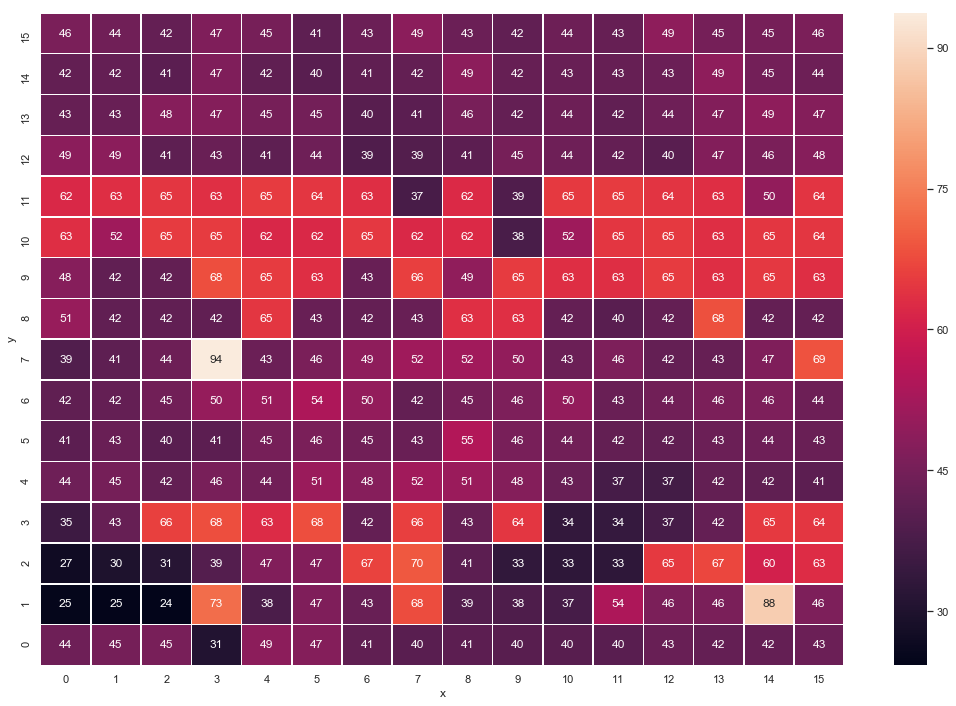

In [192]:
durations_l8 = df_duration_l8.pivot("y", "x", "duration")

f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(durations_l8, annot=True,  linewidths=.5, ax=ax)

In [23]:
db_gpu_master = db.gpu_master
df_gpu_master = pd.DataFrame(list(db_gpu_master.find()))

In [24]:
test = pd.merge(df_duration_l8, df_gpu_master, left_on='hostname', right_on='hostname', how='left')

In [25]:
test.head()

,jobId_x,level,taskId,x,y,duration,hostname,_id,gpuSerial,gpuUUID,hostnumber
0,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,00412c8d-7c0e-4017-bf28-b06dd118b683,14,4,41.537,cd44f5819eba427a816e7ce648adceb200000E,5c4545357653792f7ecda1e9,323617042890,GPU-938ef655-c524-d16d-6e28-67a434cc510c,535
1,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,024a45d1-04c4-4908-a03c-6c7c57ed1ac5,10,12,43.886,04dc4e9647154250beeee51b866b071500000M,5c4545357653792f7ecda086,323217056678,GPU-0a1cc8af-77e5-09ba-3a20-254f96cf9880,180
2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,0363ce87-954c-4635-832a-49f5899f90f8,0,15,45.821,2ecb9d8d51bc457aac88073f6da0546100000Z,5c4545357653792f7ecda12f,323617020934,GPU-871d4230-76db-f266-8b92-3e35943e8dc7,349
3,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,03831d0b-4939-4de1-9717-164765b90266,4,2,46.903,6139a35676de44d6b61ec247f0ed865700001D,5c4545357653792f7ecd9fd8,320118118795,GPU-7662ee39-8822-2f95-9c68-18a9dc4feece,6
4,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,8,04cf0a46-41b7-4970-bd4f-84968b151ed4,3,1,72.533,4a79b6d2616049edbf06c6aa58ab426a00000V,5c4545357653792f7ecda272,325017017662,GPU-4ebdd000-216f-494b-18c3-8e399c7183b9,672


In [193]:
test.sort_values(by=['y'], ascending=False)
hostname_l8 = test.pivot("y", "x", "hostnumber")

hostname_l8.sort_index(level=0, ascending=False, inplace=True)
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(hostname_l8, annot=True,  fmt='d', linewidths=.5, ax=ax)

NameError: name 'test' is not defined

In [40]:
hostname_l8

x,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
y,,,,,,,,,,,,,,,,
0,202,568,177,513,113,575,195,281,637,361,178,367,182,222,359,950
1,82,777,878,672,695,81,772,124,466,211,489,433,834,340,158,416
2,266,972,483,418,6,902,212,265,443,87,140,384,1011,23,421,438
3,231,398,910,767,149,904,190,606,71,898,223,217,893,865,843,1014
4,99,404,208,131,210,152,860,501,393,768,401,184,335,322,535,531
5,452,170,297,228,299,506,383,578,432,156,258,534,499,110,468,357
6,97,244,399,552,279,130,422,702,469,293,369,497,378,151,1,353
7,72,142,502,813,302,426,478,80,254,992,68,284,403,273,815,714
8,991,703,218,974,872,701,663,690,444,595,780,385,400,352,309,482


In [37]:
db_gpu_summary = db.apps
df_gpu_summary = pd.DataFrame(list(db_gpu_summary.aggregate([
    {"$group" : {"_id":"$taskId", "count":{ "$sum":1}}}
])))

In [39]:
#df_gpu_summary
df_gpu_summary.sort_values(by=['count'])

,_id,count
0,93d8cfdd-2296-4f90-a436-83bc4ade2bd4,10
43805,1c867a8b-4b3e-41af-972b-0de537acf5df,10
43806,dad9b438-9695-429b-8781-52dd2a46302e,10
43807,0c4aab36-6015-4bab-ae41-37d54f07abb7,10
43808,03000ce8-14f9-4001-a1c2-c29ada66cef5,10
43809,db26ee66-de82-4bdb-a773-0283e4d39351,10
43810,5e616922-5543-49ec-95b0-3b67d9823a6a,10
43811,3d611009-6571-4725-b77c-1d31099e17fb,10
43812,95da60d9-b879-4e2f-a04b-982e20219584,10
43813,dad9e420-37d2-4264-b53b-3e91a442189c,10


level 12 tile

In [194]:
df_taskXY_l12_set = df_taskXYset[(df_taskXYset['level'] == 12)]
df_taskXY_l12_set.set_index('taskId')
len(df_taskXY_l12_set)

65536

In [195]:
taskset_l12 = db.taskids_host
df_taskset_l12 = pd.DataFrame(list(taskset_l8.find({'eventName': 'TotalRender'})))

In [196]:
df_taskset_l12.columns
len(df_taskset_l12)

66040

In [197]:
df_duration_l12 = pd.merge(df_taskXY_l12_set, df_taskset_l12, left_on='taskId', right_on='taskid', how='left')
print(df_duration_l12.columns)

Index(['_id_x', 'jobId_x', 'level', 'taskId', 'x', 'y', '_id_y', 'duration',
       'eventName', 'hostname', 'jobId_y', 'startTime', 'stopTime', 'taskid'],
      dtype='object')


In [198]:
df_duration_l12 = df_duration_l12.iloc[:, [1,2,3,4,5,7,9]]
df_duration_l12['duration'] = df_duration_l12['duration']/1000


In [199]:
df_duration_l12.drop_duplicates(subset ="taskId", keep = 'first', inplace = True) 
len(df_duration_l12)

65536

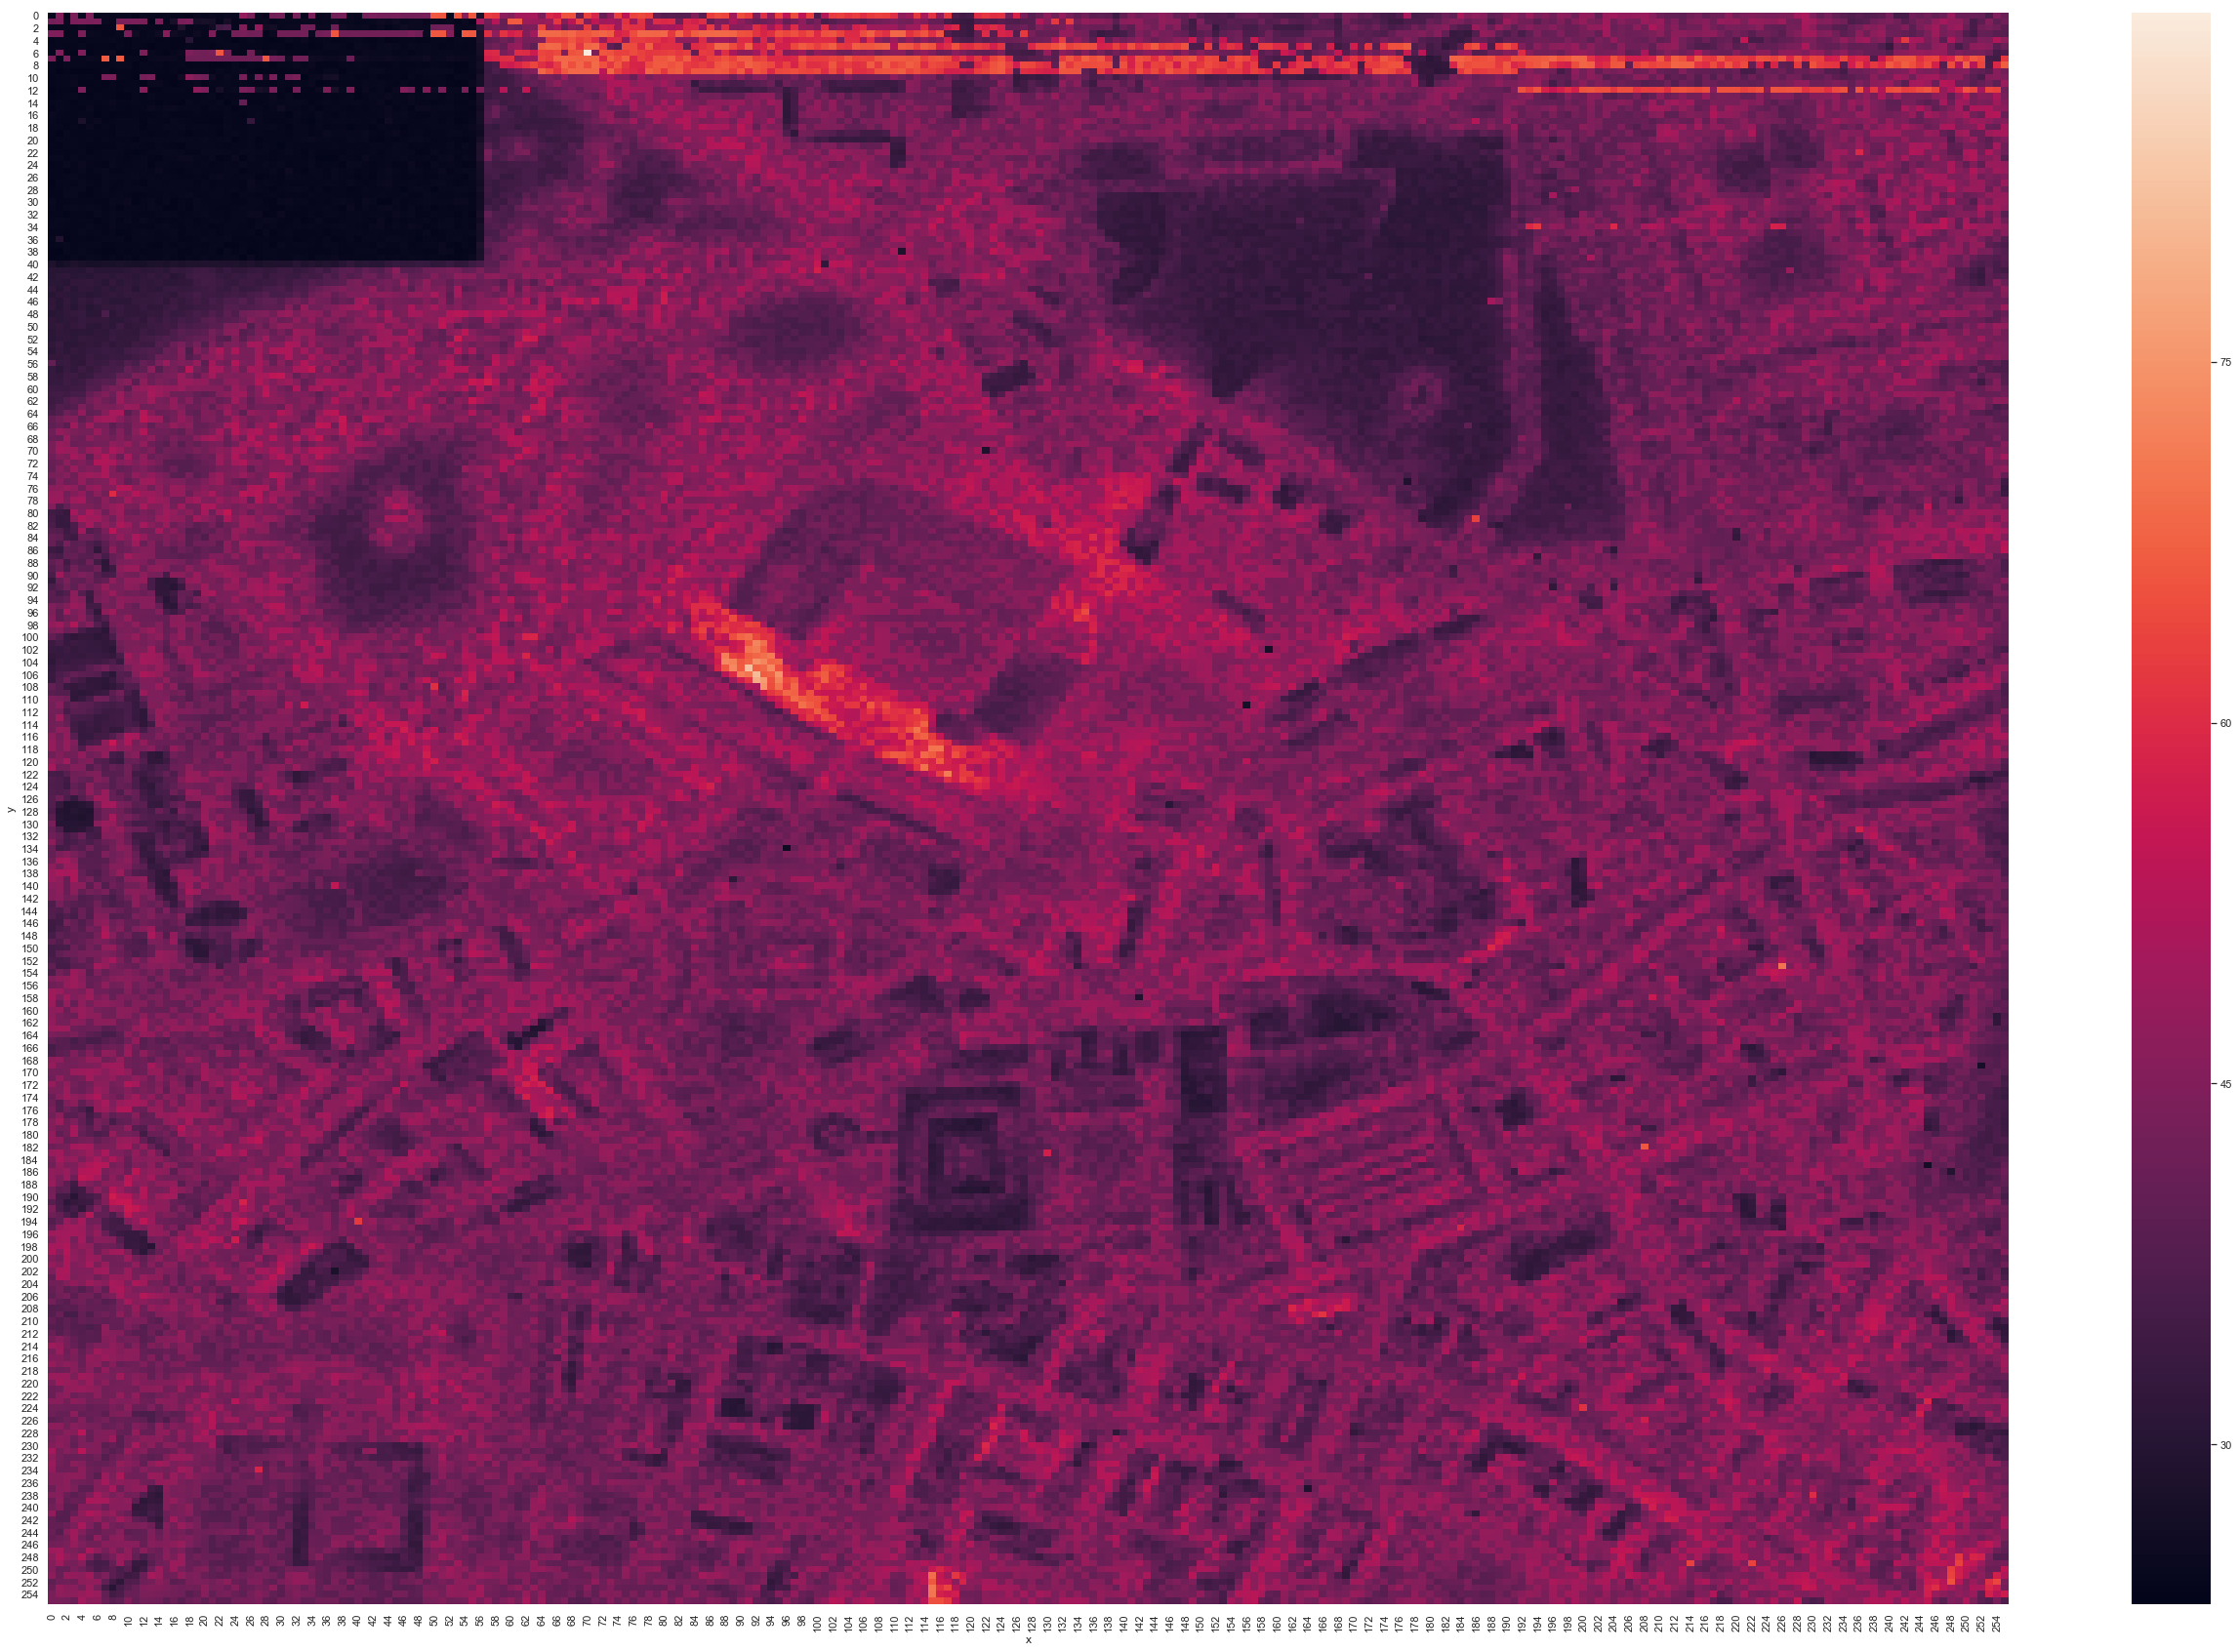

In [209]:
durations_l12 = df_duration_l12.pivot("y","x" , "duration")
#durations_l12.sort_index(level=1, ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(45, 30))
sns.heatmap(durations_l12,  linewidths=0, ax=ax)

In [51]:
durations_l12

x,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
y,,,,,,,,,,,,,,,,,,,,,
0,24.627,45.483,24.393,44.146,24.672,44.434,24.569,25.016,24.534,24.695,...,40.070,41.677,48.411,40.974,41.372,41.030,40.494,36.308,44.604,41.289
1,43.248,43.856,24.953,43.869,44.417,44.033,44.324,25.308,24.587,44.076,...,47.508,50.389,47.444,47.015,42.935,35.685,39.072,45.256,39.465,42.594
2,24.413,24.418,24.711,24.218,24.924,24.215,23.958,24.297,24.355,66.302,...,49.508,43.772,47.568,48.952,41.247,35.865,41.846,43.505,41.811,39.271
3,44.470,44.776,24.264,24.504,44.239,24.989,24.879,24.326,24.377,24.739,...,49.189,43.073,44.921,43.252,37.131,35.202,40.643,40.090,38.626,38.170
4,24.060,24.515,24.504,24.541,24.111,24.547,24.579,24.656,24.741,24.339,...,46.229,39.354,52.257,44.330,40.591,39.997,44.388,43.866,52.311,47.335
5,24.394,24.627,24.320,24.282,24.899,23.924,24.215,24.167,23.934,24.553,...,46.985,48.342,41.318,35.970,40.090,46.631,47.400,45.892,38.671,41.582
6,24.637,44.728,24.182,24.094,44.612,23.505,24.400,24.272,25.091,23.752,...,48.528,47.667,42.189,44.702,42.760,43.165,43.342,41.486,35.357,36.827
7,43.896,24.295,44.327,24.493,24.435,24.948,24.821,67.008,24.443,66.941,...,63.925,57.298,58.951,66.057,62.485,66.383,64.941,35.311,34.591,62.130
8,24.471,24.257,24.826,24.507,24.528,24.232,24.256,24.338,24.655,24.863,...,57.845,37.963,64.773,52.898,67.358,53.347,63.712,36.023,59.429,67.107


## Conclusion

According to several reasons, I cannot implement all the 12 rules.  
    Not enough case
    In this project, there is no baseline to compare the absolute measurement "rule number 1"
    not enough knowledge about performance benchmarking subject
    
Very interesting topic to benchmark cloud performance, and also in this area there are still research question

## References
Hoefler, T. and Belli, R. (2015). Scientific benchmarking of parallel computing systems. Proceedings of the International Conference for High Performance Computing, Networking, Storage and Analysis on - SC '15.

Images.nvidia.com. (2019). [online] Available at: https://images.nvidia.com/content/tesla/pdf/Tesla-V100-PCIe-Product-Brief.pdf [Accessed 23 Jan. 2019].